In [ ]:
import pandas as pd
import numpy as np
import ast
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, PCA
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# < -- LOAD DATA -- >
# Tracks with metadata
df_tracks = pd.read_csv("DATA/spotify_genius_data_noduplicates.csv")
df_tracks.rename(columns={"spotify_id": "song_id"}, inplace=True)

# Tokenized lyrics
tokenized_data = pd.read_csv("DATA/tokenized_data.csv")
tokenized_data["tokens_no_stop"] = tokenized_data["tokens_no_stop"].apply(ast.literal_eval)

# Community assignments
communities_df = pd.read_csv("DATA/communities.csv")

# < -- MERGE TRACKS WITH COMMUNITIES & SENTIMENT -- >
# Keep only songs with community info
df = df_tracks.merge(communities_df[["song_id", "community_id", "degree"]],
                     on="song_id", how="inner")

# Compute sentiment
analyzer = SentimentIntensityAnalyzer()
df["lyrics"] = df["lyrics"].fillna("")
df["sentiment"] = df["lyrics"].apply(lambda txt: analyzer.polarity_scores(txt)["compound"])

# Extract release year
df["year"] = pd.to_datetime(df["release_date"], errors="coerce", format="mixed").dt.year
df.dropna(subset=["year", "sentiment"], inplace=True)
df["year"] = df["year"].astype(int)

# < -- TOPIC MODELING -- >
# Prepare documents for topic modeling
tokenized_data = tokenized_data.rename(columns={"song_id": "song_id"})
tokenized_data["joined_lyrics"] = tokenized_data["tokens_no_stop"].apply(lambda toks: " ".join(toks))

# TF-IDF + NMF
tfidf = TfidfVectorizer(max_df=0.9, min_df=5, max_features=5000)
tfidf_matrix = tfidf.fit_transform(tokenized_data["joined_lyrics"])
nmf = NMF(n_components=10, random_state=0)
topic_matrix = nmf.fit_transform(tfidf_matrix)

# Assign dominant topic
tokenized_data["dominant_topic"] = topic_matrix.argmax(axis=1)

# < -- COMMUNITY-LEVEL THEMATICS -- >
# Build tokens_count per community
merged_tokens = (
    tokenized_data.explode("tokens_no_stop")[["song_id", "tokens_no_stop"]]
      .rename(columns={"tokens_no_stop": "token"})
      .merge(communities_df[["song_id", "community_id"]], on="song_id", how="inner")
)

community_tokens = (
    merged_tokens.groupby(["community_id", "token"])
                 .size()
                 .reset_index(name="count")
)

# Compute TF-IDF per community
totals = community_tokens.groupby("community_id")["count"].sum().reset_index(name="total")
tokens_count = community_tokens.merge(totals, on="community_id")
tokens_count["tf"] = tokens_count["count"] / tokens_count["total"]
df_dfreq = tokens_count.groupby("token")["community_id"].nunique().reset_index(name="df_comm")
N = tokens_count["community_id"].nunique()
tokens_count = tokens_count.merge(df_dfreq, on="token")
tokens_count["idf"] = np.log(N / tokens_count["df_comm"])
tokens_count["tf_idf"] = tokens_count["tf"] * tokens_count["idf"]

# Identify top 5 communities by distinct artist count
top_communities = (
    df.groupby("community_id")["primary_artist"]
      .nunique()
      .sort_values(ascending=False)
      .head(5)
      .index
      .tolist()
)

# < -- VISUALIZATIONS -- >
plt.style.use('default')

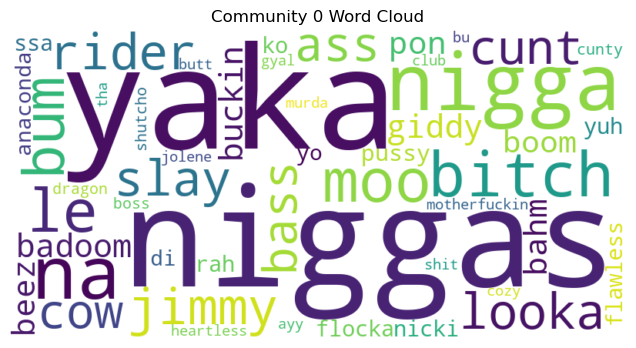

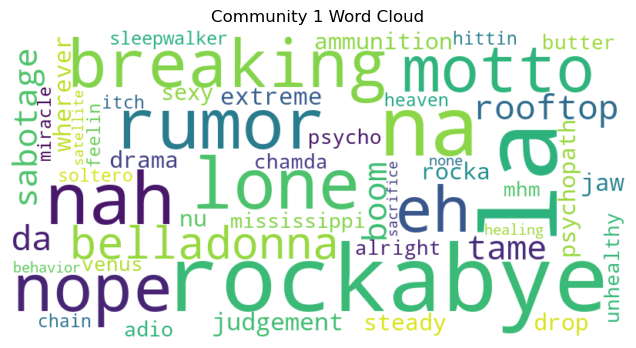

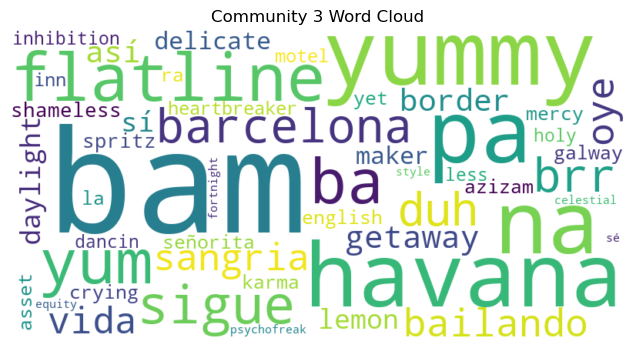

In [ ]:
# Word clouds for top communities
for cid in top_communities[:3]:
    freqs = tokens_count.query("community_id==@cid and tf_idf>0") \
                        .nlargest(50, "tf_idf") \
                        .set_index("token")["tf_idf"].to_dict()
    if not freqs:
        continue
    wc = WordCloud(width=800, height=400, max_words=50,
                   background_color="white").generate_from_frequencies(freqs)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Community {cid} Word Cloud")
    plt.show()

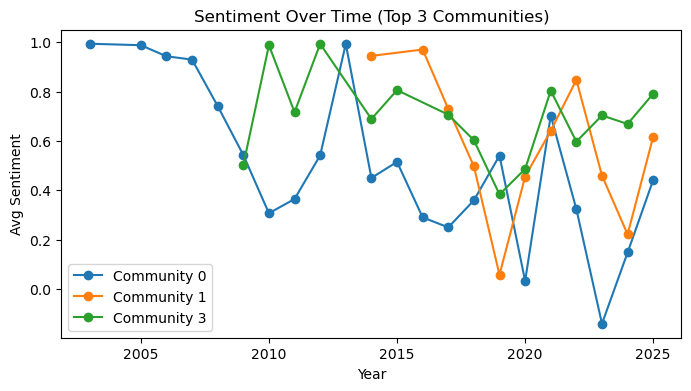

In [ ]:
# Average sentiment over time for top 3 communities
top3 = top_communities[:3]
plt.figure(figsize=(8,4))
for cid in top3:
    grp = df[df["community_id"]==cid]
    yearly = grp.groupby("year")["sentiment"].mean()
    plt.plot(yearly.index, yearly.values, marker="o", label=f"Community {cid}")
plt.xlabel("Year"); plt.ylabel("Avg Sentiment")
plt.title("Sentiment Over Time (Top 3 Communities)")
plt.legend(); plt.show()

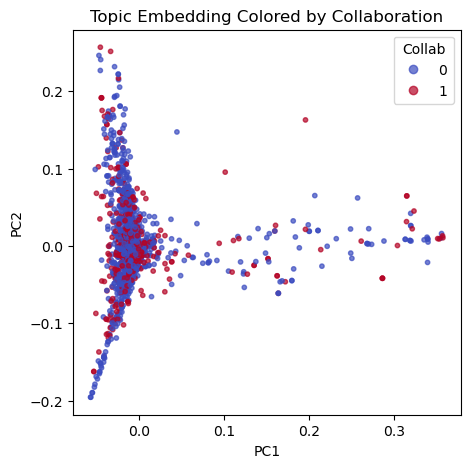

In [ ]:
# PCA of topics colored by collaboration flag
df_meta = df_tracks.merge(tokenized_data[["song_id", "dominant_topic"]], on="song_id", how="inner")
pc = PCA(n_components=2).fit_transform(topic_matrix)
colors = df_meta["is_collaboration"].map({True:1, False:0})
plt.figure(figsize=(5,5))
scatter = plt.scatter(pc[:,0], pc[:,1], c=colors, cmap="coolwarm", s=10, alpha=0.7)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("Topic Embedding Colored by Collaboration")
plt.legend(*scatter.legend_elements(), title="Collab"); plt.show()

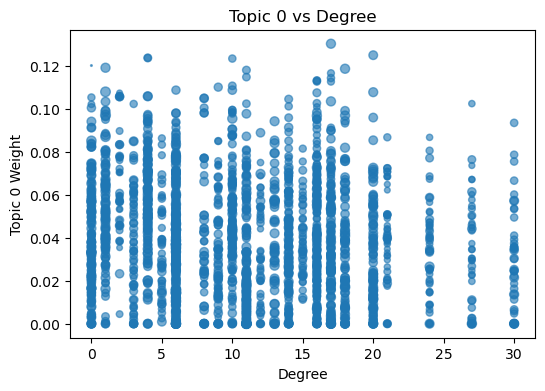

In [ ]:
# Topic 0 weight vs degree (collaboration count)
df_plot = df.merge(pd.DataFrame(topic_matrix, index=tokenized_data["song_id"])[0]
                   .reset_index().rename(columns={0:"topic0"}), on="song_id")
plt.figure(figsize=(6,4))
plt.scatter(df_plot["degree"], df_plot["topic0"], s=df_plot["popularity"]/2, alpha=0.6)
plt.xlabel("Degree"); plt.ylabel("Topic 0 Weight")
plt.title("Topic 0 vs Degree"); plt.show()